In [1]:
import tensorflow as tf
import cv2
import xml.etree.ElementTree as ET
import os
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import Dense, Activation, Dropout, Flatten

In [2]:
data_dir = 'D:\\Facial Expression Database\\images with all xml\\images and xml\\'
images_dir = 'D:\\Facial Expression Database\\images with all xml\\images'
xml_dir = 'D:\\Facial Expression Database\\images with all xml\\xml'

In [3]:
img_size = (224,224)

images = []
action_units = [[0]*27 for _ in range(227)]

In [4]:
# Map each image file name to its corresponding index in the labels array using a dictionary
image_file_to_index = {}
for i, filename in enumerate(os.listdir(images_dir)):
    # assume the file extension is '.jpg'
    image_file_to_index[filename[:-4]] = i


In [5]:
for xml_file in os.listdir(data_dir):
    if xml_file.endswith(".xml"):
        xml_path = os.path.join(data_dir, xml_file)
        tree = ET.parse(xml_path)
        root = tree.getroot()
        # Extract the image file name from the XML file and use the dictionary to get its corresponding index in the labels array
        image_file_name = xml_file[:-4]
        index = image_file_to_index[image_file_name]
        #print(index)
        # Loop through all the "ActionUnit" elements in the XML file and update the corresponding index in the labels array
        au = root.findall('.//ActionUnit')
        for child in au:
            if child.get('Number').isdigit():
                action_unit = child.get('Number')
                if int(action_unit) < 28: 
                    action_units[index][int(action_unit)-1] = 1


In [6]:
# Loop through the images and resize them
for image_file in os.listdir(data_dir):
    if image_file.endswith(".jpg"):
        image_path = os.path.join(data_dir, image_file)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, img_size)
        #print("image: {} added".format(image_file))
        images.append(image)

In [7]:
# Create a TensorFlow dataset from the images and action units
dataset = tf.data.Dataset.from_tensor_slices((images, action_units))

# Shuffle and batch the dataset
dataset = dataset.shuffle(buffer_size=227)
dataset = dataset.batch(batch_size=2)

In [8]:
print(f'dataset size: {dataset.cardinality().numpy()}')

dataset size: 114


In [9]:
train_size = int(dataset.cardinality().numpy()*0.8)
test_size = int(dataset.cardinality().numpy()*0.2)
print(train_size)

91


In [10]:
train_dataset = dataset.take(train_size)
test_dataset = dataset.skip(train_size).take(test_size)

print(f'Training dataset size: {train_dataset.cardinality().numpy()}')
print(f'Testing dataset size: {test_dataset.cardinality().numpy()}')


Training dataset size: 91
Testing dataset size: 22


In [11]:
def normalize_data(image, label):
    
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, img_size)
    return image, label

In [12]:
normalized_train_dataset = train_dataset.map(normalize_data)
normalized_test_dataset = test_dataset.map(normalize_data)

def get_label(x, y):
    return y

# Map the get_label function to each element of the dataset
label_dataset = normalized_train_dataset.map(get_label)

# Print the labels from the dataset
for label in label_dataset:
    print(label.numpy())

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
[[0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
[[0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]]
[[0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
[[1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0]]
[[0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding = 'valid', activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dense(27, activation='sigmoid'))

model.summary()


In [ ]:
# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

import datetime

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = [tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1), tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)] 
history = model.fit(normalized_train_dataset, epochs=50, batch_size=2, callbacks=[tensorboard_callback])

In [ ]:
model.evaluate(normalized_test_dataset)

In [ ]:
model.save('action_unit_detection_v5')

# Confusion Matrix Creation

In [13]:
model = tf.keras.models.load_model('action_unit_detection_v5')

In [ ]:
history.history

In [14]:
import matplotlib.pyplot as plt

In [ ]:
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [15]:
pred = model.predict(normalized_test_dataset)

22/22 [==============================] - 1s 2ms/step


In [16]:
pred

array([[3.1761928e-08, 6.2429844e-09, 3.7528006e-37, ..., 9.9984825e-01,
        9.9591428e-01, 1.3100120e-05],
       [2.6553130e-07, 8.8780399e-07, 9.5074580e-35, ..., 9.9950922e-01,
        5.3197607e-12, 9.4120979e-04],
       [1.0158442e-02, 1.8763515e-03, 3.1693936e-10, ..., 2.3261120e-05,
        1.3334678e-03, 4.4934113e-06],
       ...,
       [1.6982352e-06, 6.2613217e-05, 6.3079715e-11, ..., 2.0979287e-04,
        2.0597241e-08, 6.4486102e-08],
       [2.7807127e-04, 1.0738227e-06, 8.4344298e-19, ..., 4.1697182e-05,
        4.2933146e-09, 1.1007429e-15],
       [9.3349888e-09, 5.1712469e-08, 5.3310020e-28, ..., 9.8331016e-05,
        9.9998951e-01, 7.2539932e-11]], dtype=float32)

In [17]:
def get_label(x, y):
    return y

# Map the get_label function to each element of the dataset
label_dataset = normalized_test_dataset.map(get_label)
y_true = []
# Print the labels from the dataset
for label in label_dataset:
    x = label.numpy()
    y_true.append(x)
for label in label_dataset:
    x = label.numpy()
    y_true.append(x)

In [ ]:
!pip install mlxtend

In [18]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

In [20]:
y_true=np.argmax(y_true,axis=1)
y_pred=np.argmax(pred,axis=1)
print(y_true)
print(y_pred)

[ 0  0  3  5 16  0  3  9 23  9 26  5 15  5 19  0 13 18  9  1  3 25  4  5
  3  0 18 13 22  0  3  6 21  3 14 24  0 18  0  0  0 16  3 25]
[24  9 17  8 25 25  3 25 23  3 25 23  3  3  3 18 23  1 14 24 24 12 24 21
 21  9  9  3 16 25 25  3 16 18 17 16 17  3  0  1 19  3 16 25]


In [21]:
print(len(y_true))
print(len(y_pred))
y_true_flat = np.array(y_true).flatten()
y_pred_flat = np.array(y_pred).flatten()

44
44


C:\Users\Eddie\anaconda3\lib\site-packages\mlxtend\plotting\plot_confusion_matrix.py:102: RuntimeWarning: invalid value encountered in divide
  normed_conf_mat = conf_mat.astype("float") / total_samples


(<Figure size 1000x1000 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

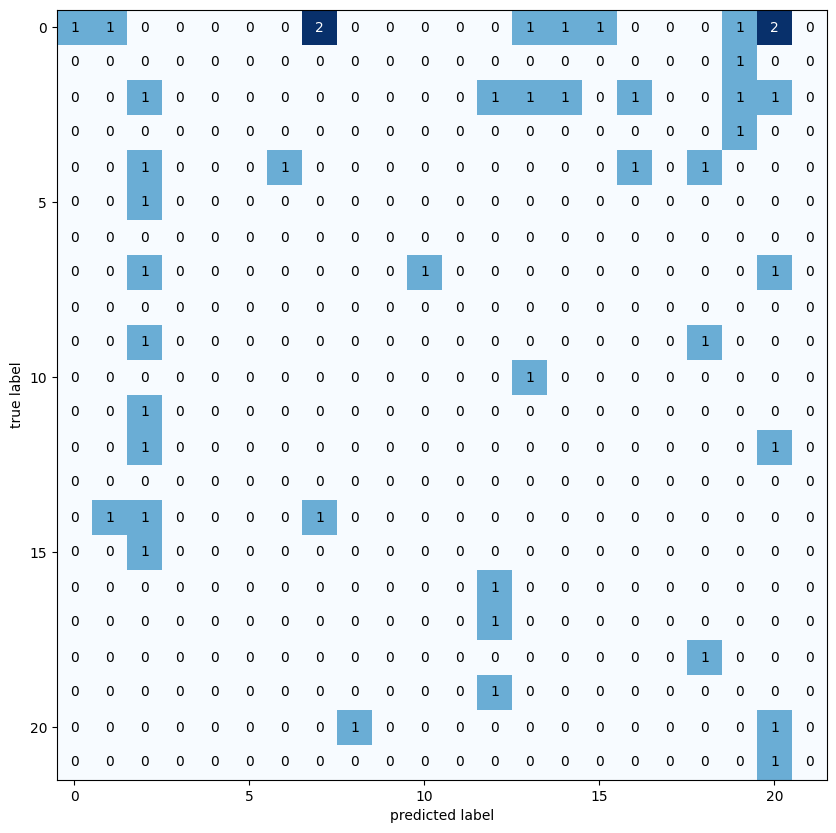

In [22]:
mat = confusion_matrix(y_true_flat,y_pred_flat)
plot_confusion_matrix(conf_mat=mat, figsize=(10,10))

In [24]:

# classification accuracy
accuracy = (mat[0,0] + mat[1,1]) / sum(sum(mat))

# error rate
error_rate = (mat[0,1] + mat[1,0]) / sum(sum(mat))

# sensitivity (true positive rate)
sensitivity = mat[1,1] / (mat[1,1] + mat[1,0])

# specificity (true negative rate)
specificity = mat[0,0] / (mat[0,0] + mat[0,1])

# positive likelihood ratio
pl_ratio = sensitivity / (1 - specificity)

# negative likelihood ratio
nl_ratio = (1 - sensitivity) / specificity

print('Classification accuracy:', accuracy)
print('Error rate:', error_rate)
print('Sensitivity:', sensitivity)
print('Specificity:', specificity)
print('Positive likelihood ratio:', pl_ratio)
print('Negative likelihood ratio:', nl_ratio)

Classification accuracy: 0.022727272727272728
Error rate: 0.022727272727272728
Sensitivity: nan
Specificity: 0.5
Positive likelihood ratio: nan
Negative likelihood ratio: nan


C:\Users\Eddie\AppData\Local\Temp\ipykernel_18844\507580153.py:8: RuntimeWarning: invalid value encountered in scalar divide
  sensitivity = mat[1,1] / (mat[1,1] + mat[1,0])


In [23]:
from sklearn.utils.multiclass import unique_labels
import pandas as pd
unique_labels(y_pred)

array([ 0,  1,  3,  8,  9, 12, 14, 16, 17, 18, 19, 21, 23, 24, 25],
      dtype=int64)

In [ ]:
def plot(y_true1, y_pred):
    labels = unique_labels(y_true)
    column = [f'Predicted au+1: {label}' for label in labels]
    index = [f'Actual au+1: {label}' for label in labels]
    print(len(index))
    print(len(column))
    print(confusion_matrix(y_true1,y_pred))
    table = pd.DataFrame(confusion_matrix(y_true1,y_pred), columns=column, index=index)
    
    return table
    

In [ ]:
plot(y_true,y_pred)

#  Live Model Test

In [ ]:
# Define a dictionary mapping action unit indexes to FACS AUs
au_mapping = {
    0: 'Inner Brow Raiser',
    1: 'Outer Brow Raiser',
    2: 'Neutral',
    3: 'Brow Lowerer',
    4: 'Upper Lid Raiser',
    5: 'Cheek Raiser',
    6: 'Lid Tightener',
    7: 'Neutral',
    8: 'Nose Wrinkler',
    9: 'Upper Lip Raiser',
    10: 'Nasolabial Deepener',
    11: 'Lip Corner Puller',
    12: 'Cheek Puffer',
    13: 'Dimpler',
    14: 'Lip Corner Depressor',
    15: 'Lower Lip Depressor',
    16: 'Chin Raiser',
    17: 'Lip Puckerer',
    18: 'Neutral',
    19: 'Lip Puckerer',
    20: 'Neutral',
    21: 'Lip Funneler',
    22: 'Lip Tightener',
    23: 'Lip Pressor',
    24: 'Lips Part',
    25: 'Jaw Drop',
    26: 'Mouth Stretch',
    27: 'Lip Suck',
}


In [ ]:
# Define the facial landmark detector
detector = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

# Define the video capture device
cap = cv2.VideoCapture(0)

while True:
    # Capture a frame from the video capture device
    ret, frame = cap.read()
    
    # Detect the faces in the grayscale frame
    faces = detector.detectMultiScale(frame, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    
    emotion = ''
    
    # For each face, predict the facial action units and corresponding emotion
    for (x, y, w, h) in faces:
        # Extract the face region from the grayscale frame
        face = frame[y:y+h, x:x+w]
        
        # Resize the face region to (224, 224) and normalize it
        face = cv2.resize(face, (224, 224))
        face = face.astype('float32') / 255.0
        face = np.expand_dims(face, axis=0)
        
        # Predict the facial action units using the trained model
        action_units = model.predict(face)[0]
        
        # Predict the corresponding emotion based on the detected action units
        # Map the predicted action units to FACS AUs
        predicted_facs_au = [au_mapping[i] for i, value in enumerate(action_units) if value >= 0.5]
        print(predicted_facs_au) 
        if 'Lips Part' and 'Lip Corner Puller' in predicted_facs_au:
            emotion = 'Happy'
        elif 'Brow Lowerer' and  'Lip Corner Depressor' in predicted_facs_au:
            emotion = 'Sadness'
        elif 'Lips Part' and  'Mouth Stretch' in predicted_facs_au:
            emotion = 'Suprise'
        elif 'Inner Brow Raiser' and 'Brow Lowerer' and 'Lip Stretcher' and 'Lips Part' in predicted_facs_au:
            emotion = 'Fear'
        elif 'Nose Wrinkler' and 'Upper Lip Raiser' and 'Chin Raiser' in predicted_facs_au:
            emotion = 'Disgust'
        elif 'Brow Lowerer' and 'Lid Tightener' and 'Lip Pressor' in predicted_facs_au:
            emotion = 'Anger'
        else:
            emotion = 'Neutral'
        
        # Draw a rectangle around the face and display the detected emotion(s)
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv2.putText(frame, ''.join(emotion), (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
    
    # Display the frame
    cv2.imshow('Facial Action Unit Detection', frame)
    
    # Check if the 'q' key was pressed to exit the loopq
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the video capture device and close all windows
cap.release()
cv2.destroyAllWindows()